# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Импортируем модули

In [1]:
import pandas as pd
import numpy as np

#Убираем лишние предупреждения
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns #Графики
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

from tqdm.notebook import tqdm #Некоторые ячейки выполняются довольно долго, так что добавим полосу прогресса
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

#Для проверки sanity
from sklearn.dummy import DummyClassifier

#Метрики для оценки моделей 
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score



from sklearn.model_selection import GridSearchCV

Загружаем датасет

In [2]:
#Считываем данные. Если нет локального доступа - то из облачного хранилища
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Поскольку мы уже делали предобработку данных, повторно делать этого не требуется

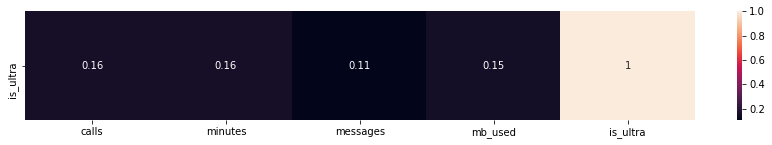

In [3]:
plt.figure(figsize=(15, 2))
sns.heatmap(data.corr(method = 'spearman')['is_ultra'].to_frame().transpose(), annot = True)
plt.show()


Мы видим низкие значения корреляции с данными, потому взаимосвязь между фичами и целевым значением скорее всего нелинейная.

## Разбейте данные на выборки

Смотрим на то, насколько выборка сбалансированна

In [4]:
data['is_ultra'].mean()

0.30647168637212197

Мы видим, что целевой параметр не сбалансирован, то есть, нужно следить за тем, чтобы он сожержался в обучающей, валидационной и тестовой выборках равномерно.Разбиваем на три части таким образом, чтобы относительное распределение целевого параметра было одинаково. 

In [5]:
train, validate, test = \
              np.split(data.sample(frac=1, random_state=42),
                       [int(.6*len(data)), int(.8*len(data))])


#Проверяем, правильно ли мы разбили выборку
print(train['is_ultra'].mean(), validate['is_ultra'].mean(), test['is_ultra'].mean())
print(len(train), len(validate), len(test))

0.30549792531120334 0.30637636080870917 0.3094867807153966
1928 643 643


Выборка разделена в соотношении 60%/20%/20%. Теперь надо разделить наши выборки на фичи и целевые значения

In [6]:
target_train = train['is_ultra']
features_train = train.drop(columns = 'is_ultra')
target_validate = validate['is_ultra']
features_validate = validate.drop(columns = 'is_ultra')
target_test = test['is_ultra']
features_test = test.drop(columns = 'is_ultra')

## Исследуйте модели

### DecisionTreeClassifier
Для выбора лучших параметров пройдёмся в цикле по параметру случайной глубины и минимального количества данных в одном листе для каждой глубины.

In [7]:
ml = []
best_tree = None
best_score = 0
best_f1_score = 0
best_leaf, best_depth = 0, 0

for depth in tqdm(range(1,12)):
    for leaf in 1, 10, 20, 30:
        model = DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leaf, random_state=42)
        model.fit(features_train, target_train)
        pred = model.predict(features_validate)

        if accuracy_score(pred, target_validate) > best_score:
            best_score = accuracy_score(pred, target_validate)
            best_tree = model
            best_leaf, best_depth = leaf, depth
            best_f1_score = f1_score(pred, target_validate)

tree_result = ('Лучшее дерево: максимальная глубина - ', best_depth, 
      'min samples leaf - ', best_leaf, 'accuracy_score - ', best_score, 'f1 score -', best_f1_score)

print(*tree_result)

#Записываем название модели и метрики
ml.append(('DecisionTreeClassifier', best_score, best_f1_score))

  0%|          | 0/11 [00:00<?, ?it/s]

Лучшее дерево: максимальная глубина -  11 min samples leaf -  10 accuracy_score -  0.8009331259720062 f1 score - 0.6502732240437159


Как видим, лучшая глубина - 11 при  минимальном количестве данных в листе - 10. 

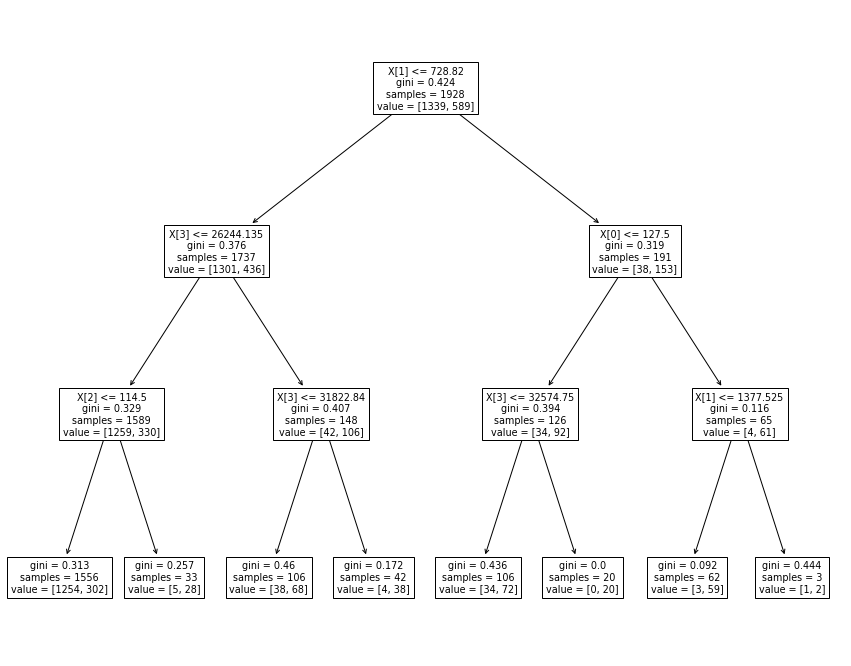

In [8]:
pt = DecisionTreeClassifier(max_depth = 3,  random_state=42)
pt.fit(features_train, target_train)
plt.figure(figsize=(15, 12))
plot_tree(pt)
plt.show()

### Случайный лес классификации
Для подбора лучшего варианта мы пройдёмся по глубине, количеству деревьев и количеству данных в листе в тройном вложенном цикле.

In [9]:
best_forest = None
best_trees, best_depth, best_leaf = 0, 0, 0
best_score, best_f1_score = 0,0
for depth in tqdm(range(1,12)):
    for trees in 1, 10, 20, 30, 50, 80, 100:
        for leaf in 1, 5, 10, 20, 50:
            model = RandomForestClassifier(max_depth = depth, n_estimators = trees,
                                           min_samples_leaf = leaf, random_state=42)
            
            model.fit(features_train, target_train)
            pred = model.predict(features_validate)
            if accuracy_score(pred, target_validate) > best_score:
                best_leaf = leaf
                best_score = accuracy_score(pred, target_validate)
                best_forest = model
                best_trees, best_depth = trees, depth
                best_f1_score = f1_score(pred, target_validate)

forest_result = ('Лучший лес: максимальная глубина - ', best_depth, 
      'n_estimators - ', best_trees, 'accueacy_score - ', best_score, 
                 'min_samples_leaf',best_leaf,'f1 score -', best_f1_score)

print(*forest_result)
ml.append(('RandomForestClassifier', best_score, best_f1_score))

  0%|          | 0/11 [00:00<?, ?it/s]

Лучший лес: максимальная глубина -  10 n_estimators -  10 accueacy_score -  0.8180404354587869 min_samples_leaf 1 f1 score - 0.6588921282798834


### Логистическая регрессия
Для подборки лучшего варианта будем изменять параметр обратной силы регуляризации. Чтобы не делать слишком длинный цикл, будем начиная со значения 10 на каждом шаге уменьшать значение в 2 раза, пока оно не будет меньше 0,0001

In [10]:
best_score, best_f1_score = 0, 0
best_linear = None
best_C = 10
current_C = 10
best_solver  = ''
solver = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
for i in tqdm(range(len(solver))):
    while current_C > 0.0001:
        model = LogisticRegression(C = current_C, random_state = 42, solver = solver[i])
        model.fit(features_train, target_train)
        pred = model.predict(features_validate)
        current_C = current_C / 2
        if accuracy_score(pred, target_validate) > best_score:
            best_score = accuracy_score(pred, target_validate)
            best_f1_score = f1_score(pred, target_validate)
            best_C = current_C
            best_linear = model
            best_solver = solver[i]

print('Лучшее С:', best_C, 'accuracy: ',best_score, 'f1_score: ',best_f1_score, 'solver:', best_solver)
ml.append(('LogisticRegression', best_score, best_f1_score))

  0%|          | 0/6 [00:00<?, ?it/s]

Лучшее С: 0.009765625 accuracy:  0.7325038880248833 f1_score:  0.3064516129032258 solver: lbfgs


Смотря на параметры точности и f1_score можно сделать вывод, что эта модель плохо подходит для задачи.

### KNeighborsClassifier
Для проверки модели будем перебирать параметр количества ближайших соседей, а также рассмотрим два варианта "голосования":
1. Не взвешенный (важно лишь количество соседий того или иного класса)
2. Взвешенный (важно также расстояние)

In [11]:
best_score = 0
best_neighbors = 0
best_weight = ''
best_KNeighborsClassifier = None
for neighbors in  tqdm(range(1, 101)):
    for weight in 'uniform', 'distance':
        model = KNeighborsClassifier(n_neighbors = neighbors, weights = weight)
        model.fit(features_train, target_train)
        pred = model.predict(features_validate)
        if accuracy_score(pred, target_validate) > best_score:
            best_score = accuracy_score(pred, target_validate)
            best_f1_score = f1_score(pred, target_validate)
            best_neighbors = neighbors
            best_weight = weight
            best_KNeighborsClassifier = model
            
neighbors_result = ('KNeighborsClassifier, лучший способ взвешивания:', 
                    best_weight, 'Лучшее количество соседий:',  best_neighbors, 'Accuracy: ', 
                    best_score, 'f1_score:', best_f1_score )
print(*neighbors_result)

ml.append(('KNeighborsClassifier', best_score, best_f1_score))

  0%|          | 0/100 [00:00<?, ?it/s]

KNeighborsClassifier, лучший способ взвешивания: distance Лучшее количество соседий: 9 Accuracy:  0.7744945567651633 f1_score: 0.5307443365695793


### Выбор лучшей модели
Выведим список всех наших моделей и их оценок. Первая оценка - точность, вторая - f1_score

In [12]:
ml

[('DecisionTreeClassifier', 0.8009331259720062, 0.6502732240437159),
 ('RandomForestClassifier', 0.8180404354587869, 0.6588921282798834),
 ('LogisticRegression', 0.7325038880248833, 0.3064516129032258),
 ('KNeighborsClassifier', 0.7744945567651633, 0.5307443365695793)]

Мы видим, что лучшие показатели у модели RandomForestClassifier

## Проверьте модель на тестовой выборке

Так как лучшая модель RandomForestClassifier - её и будем использовать.

In [13]:
pred = best_forest.predict(features_test)
print('Accuracy:', accuracy_score(pred, target_test))
print('F1Score:', f1_score(pred, target_test))

Accuracy: 0.7900466562986003
F1Score: 0.5970149253731343


Необходимое значение accuracy - 0.75, наша модель даёт показатель 0.79, что немного лучше необходимого значения. 

In [14]:
new_f = pd.concat([features_train, features_validate], ignore_index=True)
new_t = pd.concat([target_train, target_validate], ignore_index=True)
best_forest.fit(new_f,new_t)
pred = best_forest.predict(features_test)
print('Accuracy:', accuracy_score(pred, target_test))
print('F1Score:', f1_score(pred, target_test))

Accuracy: 0.7962674961119751
F1Score: 0.6042296072507553


## Проверка модели на адекватность

Для проверки модели на адекватность будем использовать DummyClassifier из модуля sklearn.dummy. Эта модель вместо предсказания, подставляет значения используя разные стратегии - случайные значения, констнатная (для неё будем использовать наиболее часто встречающееся значение False) и т.п. 

Используем все возможные стратегии для данной модели и выберим лучший результат, и сравним его с нашим. Если результаты близки, значит наша модель неадекватна, т.е. по сути возвращает случайные значения или наиболее часто встречающиеся вместо предсказания, иначе наша модель имеет смысл.

In [15]:
best_score, best_f1_score = 0, 0
stra = ''
for i in 'most_frequent','prior', 'stratified','uniform', 'constant':
    dummy = DummyClassifier(constant = False,strategy= i)
    dummy.fit(features_train, target_train)
    dpred = dummy.predict(features_test)
    if accuracy_score(dpred, target_test) > best_score:
        stra = i
        best_score = accuracy_score(dpred, target_test)
        best_f1_score = f1_score(dpred, target_test)
print('Лучшая стратегия: ', stra, 'accuracy = ', best_score,
          'f1_score = ', best_f1_score )
print('Наши значения: accuracy = ', accuracy_score(pred, target_test), 'f1Score = ', f1_score(pred, target_test))

Лучшая стратегия:  most_frequent accuracy =  0.6905132192846034 f1_score =  0.0
Наши значения: accuracy =  0.7962674961119751 f1Score =  0.6042296072507553


Значение accuracy для  DummyClassifier = 0.69, что значительно ниже нашего значения, следовательно наша модель адекватна.

### Вывод
Лучшая модель для данной выборки - RandomForestClassifier со гиперпараметрами  максимальная глубина -  10, количество деревьев -  10 и минимальное количество данных в листе 1. Также хорошая модель для нашей задачи - DecisionTreeClassifier, но её показатели хуже. Логистическая регрессия и метод К-соседей показали худшие результаты. 

При проверке на адекватность, наша модель показала положительные результаты. 